In [1]:
from multivp_dataset import MULTI_VP_Dataset
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
import numpy as np
from tqdm.notebook import tqdm
import datetime
import itertools

from models.aae import Encoder, Decoder, Discriminator
from tools.viz import plot_anomalies, plot_single_var, plot_to_tensorboard, plot_anomaly_scores, plot_train_hist, plot_data_values
from tools.anomaly import madgan_reconstruction, madgan_reconstruction_discr_loss, feature_anomaly_score

time_id = datetime.datetime.now().strftime("%m%d-%H%M")

class Options:
    def __init__(self):
        # Dataset
        self.data_path = Path('../data/compiled/inputs.csv')
        self.batch_size = 128
        self.nworkers = 4
        self.shuffle = True
        self.method = "joint"
        self.scaler = MinMaxScaler((-1, 1))
        self.l_dim = 128
        # self.wsize = 5
        
        # Train params
        self.lr = 0.0001
        self.epochs = 500
        self.sample_interval = 25
        self.train_plots = True
        
        self.model_out = Path('./runs/aae/' + time_id + f"_ldim{self.l_dim}")

        # create ouput dirs
        if not self.model_out.exists(): self.model_out.mkdir(parents=True)
        
        (self.model_out / "img").mkdir(exist_ok=True)
        
opts = Options()


# Setup Training Dataset

In [3]:
dataset = MULTI_VP_Dataset(
    path=opts.data_path,
    method=opts.method,
    remove_extreme=True,
    is_train=True,
    scaler=opts.scaler,
    # window_size=opts.wsize,
    # use_pca=True,
    # pca_scaler=MinMaxScaler((-1,1)),
    # n_components=128   
)
dataloader = DataLoader(dataset, batch_size=opts.batch_size, shuffle=True, num_workers=opts.nworkers, drop_last=False)

Removed 705 extreme values
Inputs shape: (11066, 1280)
Inputs head:
 [[-0.4834911  -0.48303799 -0.48258295 ... -1.         -1.
  -1.        ]
 [-0.47284225 -0.4723928  -0.47194147 ... -1.         -1.
  -1.        ]
 [-0.44609133 -0.44563623 -0.44517925 ... -1.         -1.
  -1.        ]
 [-0.49076893 -0.49033704 -0.4899033  ... -1.         -1.
  -1.        ]
 [-0.45617043 -0.45574015 -0.45530805 ... -1.         -1.
  -1.        ]]


Unscaled inputs shape: (11066, 1280)


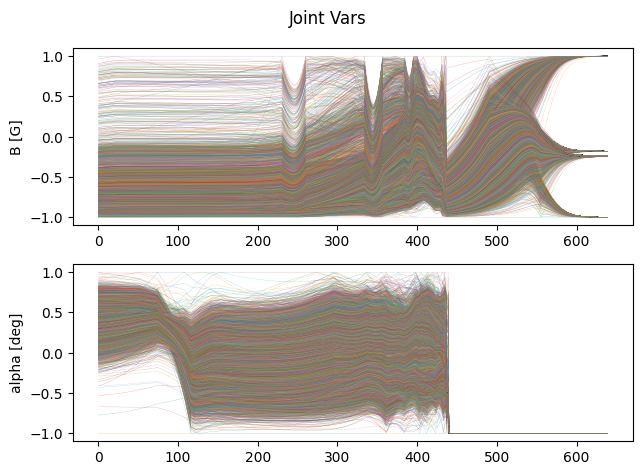

In [58]:
dataset.plot(title="Joint Vars")

# Models

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)
netEnc = Encoder(
    input_size=dataset.shape[1],
    l_dim=opts.l_dim,  
    device=device 
).to(device)
netDec = Decoder(
    output_size=dataset.shape[1],
    l_dim=opts.l_dim,
).to(device)

netD = Discriminator(
    l_dim=opts.l_dim,
).to(device)

Using device:  cuda:0


In [60]:
netEnc.train()

Encoder(
  (model): Sequential(
    (0): Linear(in_features=1280, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (mu): Linear(in_features=512, out_features=128, bias=True)
  (logvar): Linear(in_features=512, out_features=128, bias=True)
)

In [61]:
netDec.train()

Decoder(
  (model): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=512, out_features=1280, bias=True)
    (6): Tanh()
  )
)

In [62]:
netD.train()

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [63]:
logger = SummaryWriter(f"logs/aae/{time_id}_ldim{opts.l_dim}")
logger.add_text("Encoder", netEnc.__str__())
logger.add_text("Decoder", netDec.__str__())
logger.add_text("Discriminator", netD.__str__())

# Training

In [64]:
# Initialize BCELoss function
criterion = nn.BCELoss()
pixelwise_loss = nn.MSELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optmG = optim.Adam(
    itertools.chain(netEnc.parameters(), netDec.parameters()), 
    lr=opts.lr,
)
optmD = optim.Adam(netD.parameters(), lr=opts.lr)

In [65]:
# Training Loop

# Lists to keep track of progress
G_losses = []
D_losses = []
iters = 0
best_loss = np.inf
best_loss_dist = np.inf

print("Starting Training Loop...")
# For each epoch
for epoch in range(opts.epochs):
    D_epoch_loss = 0
    G_epoch_loss = 0
    
    # For each batch in the dataloader
    for i, (x, _filename) in enumerate(dataloader):
        bsize = x.shape[0]
        real_labels = torch.full((bsize, 1), real_label, dtype=torch.float, device=device)
        fake_labels = torch.full((bsize, 1), fake_label, dtype=torch.float, device=device)
        
        real = x.to(device)
        # ===== Train Generator =====
        optmG.zero_grad()
        enc_x = netEnc(real)
        dec_x = netDec(enc_x)
        
        # Loss measures generator's ability to fool the discriminator
        errG = 0.001 * criterion(netD(enc_x), real_labels) + 0.999 * pixelwise_loss(
            dec_x, real
        )
        
        errG.backward()
        optmG.step()
        
        # ===== Train Discriminator =====
        optmD.zero_grad()
        # noise as discriminator ground truth
        z = torch.rand(bsize, opts.l_dim, device=device)
        
        # discriminator ability to classify real from generated samples
        outputs = netD(z)
        errD_real = criterion(netD(z), real_labels)
        errD_fake = criterion(netD(enc_x.detach()), fake_labels)    
        errD = 0.5 * (errD_real + errD_fake)
        D_x = outputs.mean().item()
        
        errD.backward()
        optmD.step()
        
        D_epoch_loss += errD.item() / bsize
        G_epoch_loss += errG.item() / bsize
    
    # Output training stats
    print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
            % (epoch, opts.epochs, errD.item(), errG.item(), D_x, errD_fake.mean().item()),
            end='\r', flush=True)
    D_losses.append(errD.item())
    G_losses.append(errG.item())
    
    if epoch % opts.sample_interval == 0:
        dec_x = dataset.unscale(dec_x.detach().cpu().numpy())
        # fake = dataset.flatten(fake.detach().cpu().numpy())
        fig = plot_data_values(dec_x, 
                        title=f"Epoch {epoch} - G loss: {errG.item():.4f} - D loss: {errD.item():.4f}", 
                        labels=["B [G]", "alpha [deg]"],
                        scales={"alpha [deg]" : "linear"})
        plt.savefig(opts.model_out / "img" / f"e{epoch}.png")
        plt.close(fig)
    if G_epoch_loss < best_loss and epoch > 0:
        best_loss = G_epoch_loss
        torch.save(netEnc.state_dict(), opts.model_out / 'Enc.pth')
        torch.save(netDec.state_dict(), opts.model_out / 'Dec.pth')
        torch.save(netD.state_dict(), opts.model_out / 'D.pth')

Starting Training Loop...


In [66]:
logger.flush()

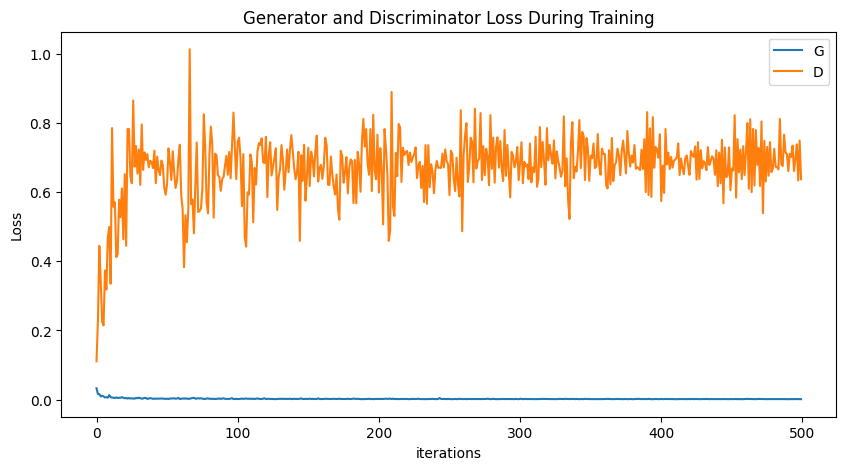

In [67]:
fig = plot_train_hist(D_losses, G_losses, opts.model_out)

# Anomaly Detection

In [5]:

netEnc.train(False)
netDec.train(False)
netD.train(False)

class AnomalyParams:
    batch_size = 128
    models_dir = opts.model_out
    models_dir = Path("./runs/aae/0315-1819_ldim128")
    # reconstruction based
    niter = 100 # number of iterations for reconstruction
    lambda_thresh = 0.1
    lr = 1e-2
    
opts_eval = AnomalyParams()

# load best models
netEnc.load_state_dict(torch.load(opts_eval.models_dir / 'Enc.pth'))
netDec.load_state_dict(torch.load(opts_eval.models_dir / 'Dec.pth'))
netD.load_state_dict(torch.load(opts_eval.models_dir / 'D.pth'))

<All keys matched successfully>

In [6]:
eval_dataset = MULTI_VP_Dataset._from(dataset)
# eval_dataset = MULTI_VP_Dataset(opts.data_path, method=opts.method, scaler=opts.scaler, window_size=10, pca=True, n_components=opts.n_components)
eval_dataloader = DataLoader(eval_dataset, batch_size=opts_eval.batch_size, shuffle=False, num_workers=opts.nworkers)

Inputs shape: (11771, 1280)
Inputs head:
 [[-0.4834911  -0.48303799 -0.48258295 ... -1.         -1.
  -1.        ]
 [-0.47284225 -0.4723928  -0.47194147 ... -1.         -1.
  -1.        ]
 [-0.44609133 -0.44563623 -0.44517925 ... -1.         -1.
  -1.        ]
 [-0.49076893 -0.49033704 -0.4899033  ... -1.         -1.
  -1.        ]
 [-0.45617043 -0.45574015 -0.45530805 ... -1.         -1.
  -1.        ]]


## Reconstruction Error

In [7]:
scores = []
loss_fn = nn.L1Loss(reduction="none")
# calculate classification scores for each sample
for i , (x, filenames) in enumerate(eval_dataloader):
    x = x.to(device)
    enc_x = netEnc(x)
    dec_x = netDec(enc_x)
    
    errG = loss_fn(dec_x, x).mean(-1)
    errG = errG.detach().cpu().tolist()
    # calculate mean classification score for each sample
    for error, filename in zip(errG, filenames):
        scores.append((filename, error))

Anomaly Threshold:  0.02812325954437256
Found 1177 anomalies


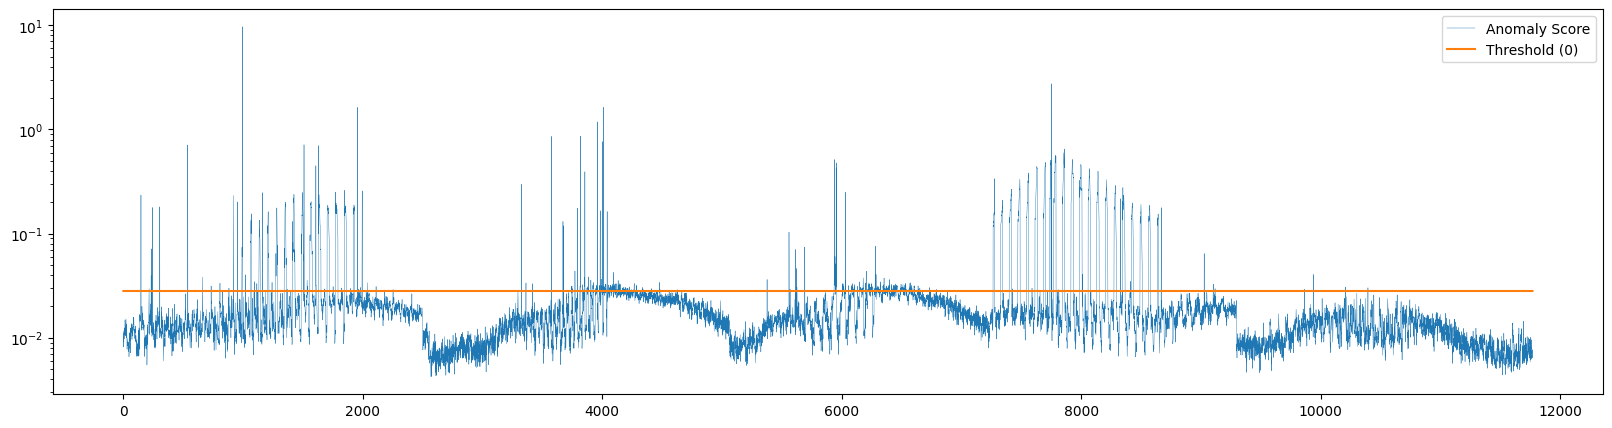

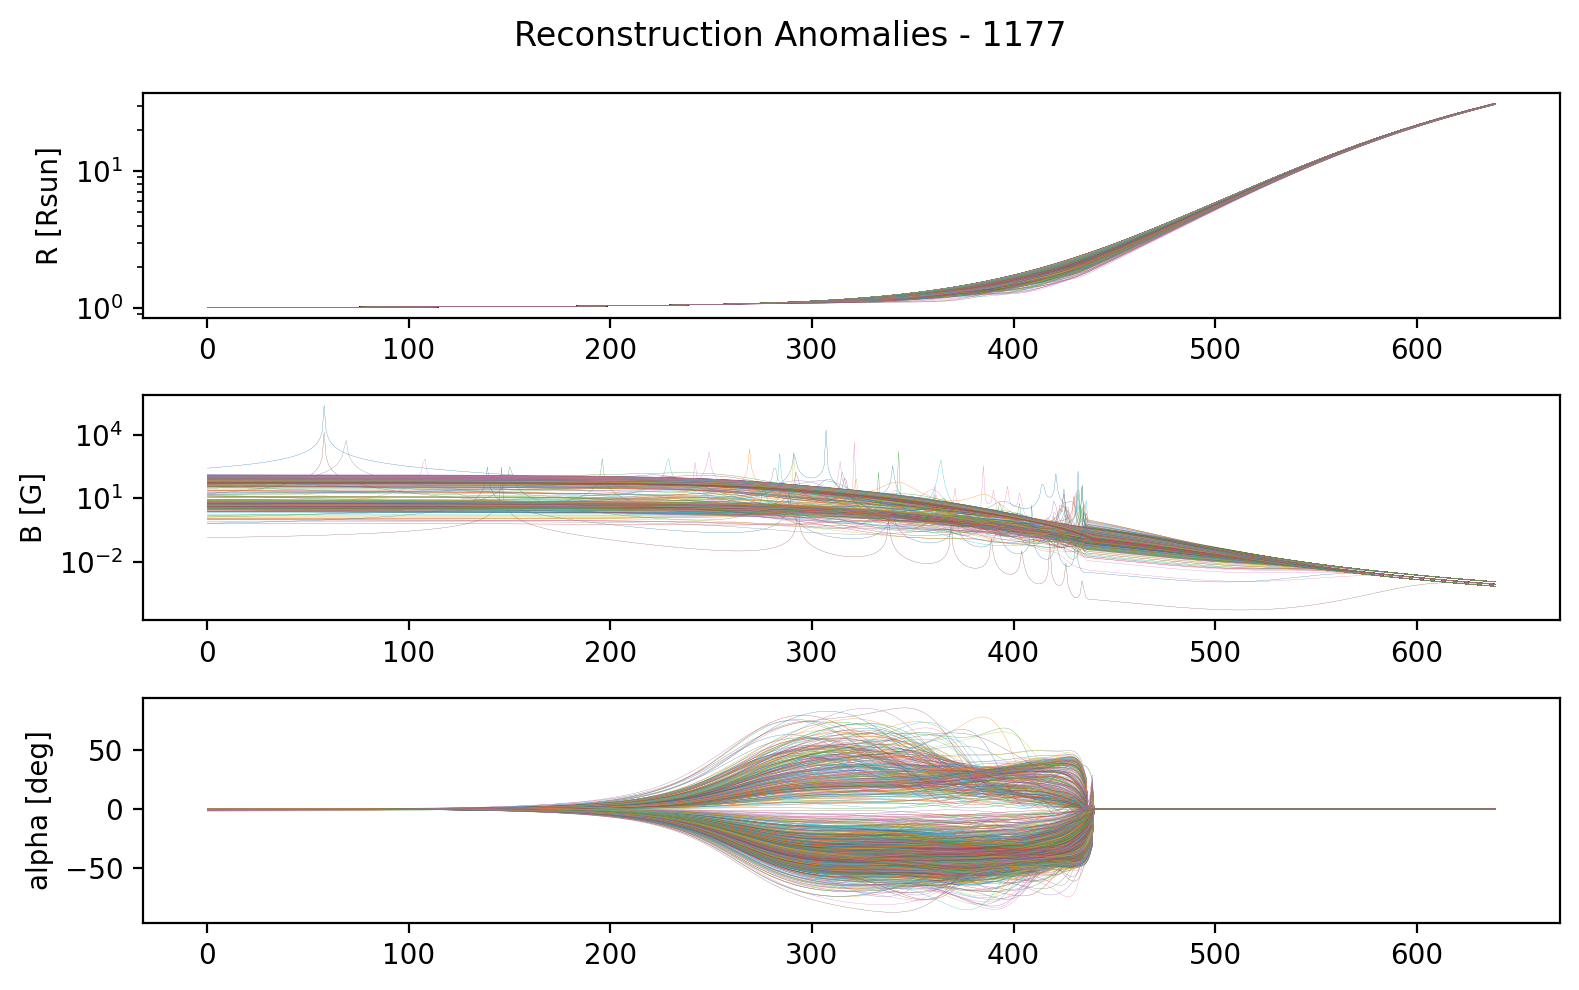

In [8]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(scores, 0.1, opts.data_path, opts_eval.models_dir /  f"img/reconstr_scores",
                        scale="log", method="Reconstruction")

## Reconstruction + Discriminator

In [9]:
scores_discr = []
loss_fn = nn.L1Loss(reduction="none")
criterion = nn.BCELoss()

# calculate classification scores for each sample
for i , (x, filenames) in enumerate(eval_dataloader):
    x = x.to(device)
    enc_x = netEnc(x)
    dec_x = netDec(enc_x)
    
    bsize = x.shape[0]
    real_labels = torch.full((bsize, 1), 1, dtype=torch.float, device=device)
    
    errG = 0.1 * criterion(netD(enc_x), real_labels) + 0.9 * loss_fn(dec_x, x).mean(-1)
    errG = errG.detach().cpu().numpy()
    # errG = loss_fn(dec_x, x).mean(-1)
    # errG = errG.detach().cpu().tolist()
    # calculate mean classification score for each sample
    for error, filename in zip(errG, filenames):
        # print(sample, filename)
        scores_discr.append((filename, error))

Anomaly Threshold:  0.111328304
Found 1177 anomalies


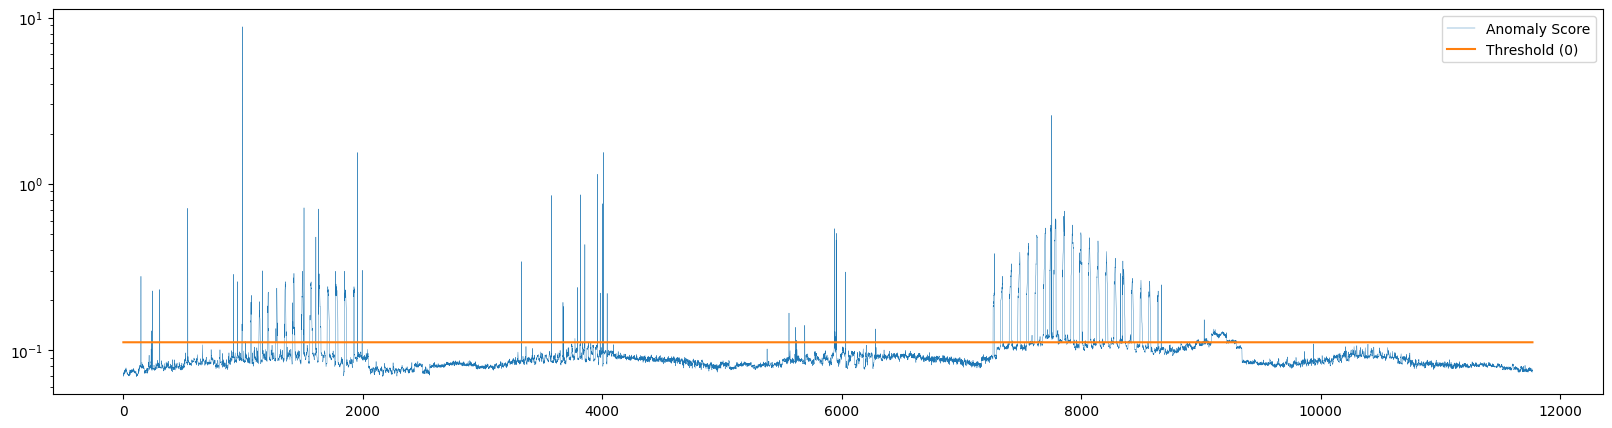

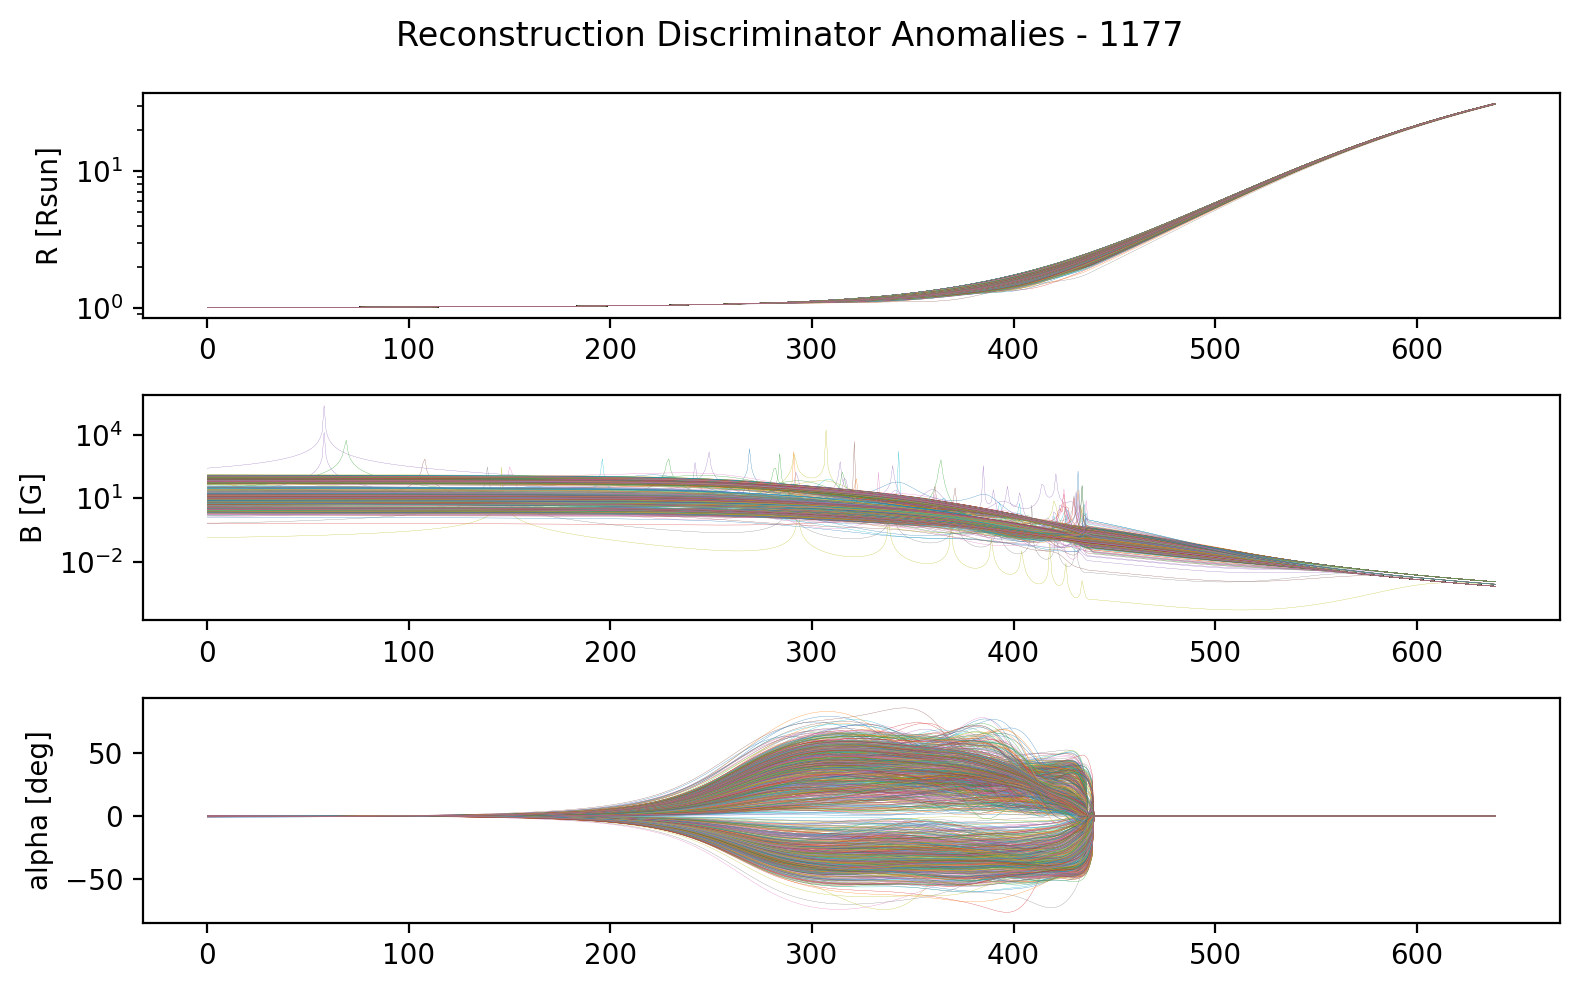

In [10]:
scores_fig, anomal_fig =\
    plot_anomaly_scores(scores_discr, 0.1, opts.data_path, opts_eval.models_dir /  f"img/reconstr_discr_scores", 
                        scale="log", method="Reconstruction Discriminator")